# Assessment of Cosmic Ray Composition Estimation

## Import Required Modules

In [1]:
%matplotlib inline

import json
import os
from glob import glob

import matplotlib.pyplot as plt
import numpy as np

from utils import get_cuts, get_event_parameters, get_training_assessment_cut

from datetime import datetime as dt
from datetime import timedelta as td

## Model and Assessment Selection

In [2]:
# The keys will be the names of the models you wish to analyze.
# The values will be the nuclei to assess for each model.
MODEL_NAMES_AND_NUCLEI = {
    'comp_baseline': 'phof',
    'comp_baselineTwo' : 'phof'
}

In [3]:
# IceTop-CNN folder in /data/user
ICETOP_CNN_DATA_DIR = os.getenv('ICETOP_CNN_DATA_DIR')
# Folder containing the models
MODELS_FOLDER_PATH = os.path.join(ICETOP_CNN_DATA_DIR, 'models')
# Folder containing the reconstructions
RECONSTRUCTIONS_FOLDER_PATH = os.path.join(ICETOP_CNN_DATA_DIR, 'reconstructions', 'comp')
# Folder containing the simulation data.
SIMDATA_FOLDER_PATH = os.path.join(os.sep, 'data', 'user', 'fmcnally', 'icetop-cnn', 'simdata')

# Various potential error messages.
ERROR_MODELS_FOLDER_PATH_NOT_FOUND = 'Could not find models folder. Path specified: '
ERROR_NO_MODELS_SELECTED = 'No models selected for analysis!'

### List Available Models

In [4]:
# Ensure that the models folder has been found.
assert os.path.exists(MODELS_FOLDER_PATH), f'{ERROR_MODELS_FOLDER_PATH_NOT_FOUND}{MODELS_FOLDER_PATH}'

# Get all model reconstructions .npy files.
model_list = glob(os.path.join(RECONSTRUCTIONS_FOLDER_PATH, '*.npy'))
# Trim parent directories and file extension for each.
model_list = [os.path.splitext(os.path.basename(model))[0] for model in model_list]

# Get all model parameters .json files.
param_list = glob(os.path.join(MODELS_FOLDER_PATH, '*', '*.json'))
# Trim parent directories and file extension for each.
param_list = [os.path.splitext(os.path.basename(param))[0] for param in param_list]

# Print models that have both .npy and .json files.
print(f'Available models: {sorted(set(model_list).intersection(param_list))}')
# Print models that have a .npy file but no .json file.
print(f'Models without parameter files: {sorted(set(model_list).difference(param_list))}')

Available models: ['comp_baseline', 'comp_baselineTwo', 'comp_js3']
Models without parameter files: []


### Load Model Parameters

In [5]:
# Create a dictionary to store model parameters.
model_parameters = {}
# Loop over model names and their corresponding assessment nuclei.
for model_name, assessment_nuclei in MODEL_NAMES_AND_NUCLEI.items():
    
    # Construct the full .json model path.
    model_path = os.path.join(MODELS_FOLDER_PATH, model_name, model_name + '.json')

    # Ensure that the model is found (no typos).
    if not os.path.exists(model_path):
        print(f'WARNING: Model {model_name} not found at {MODELS_FOLDER_PATH}')
        continue

    # Load model parameters and save into the dictionary.
    with open(model_path, 'r') as f:
        model_parameters[model_name] = json.load(f)
    # Add assessment nuclei to model parameters. Sort the composition string into a predictable order.
    model_parameters[model_name].update(
        {'assessment_nuclei': ''.join(sorted(assessment_nuclei, key=lambda c: list('phof').index(c)))})
    
    # Print an entry for each model.
    print(f'{model_name:>{max(map(len, MODEL_NAMES_AND_NUCLEI))}} : {model_parameters[model_name]}')

# Ensure that at least one valid model has been selected for assessment.
assert len(model_parameters), ERROR_NO_MODELS_SELECTED

   comp_baseline : {'infill': False, 'clc': True, 'sta5': False, 'q': None, 't': None, 't_shift': True, 'q_clip': False, 't_clip': False, 'normed': True, 'reco': None, 'training_nuclei': 'phof', 'assessment_nuclei': 'phof'}
comp_baselineTwo : {'infill': False, 'clc': True, 'sta5': False, 'q': None, 't': None, 't_shift': True, 'q_clip': False, 't_clip': False, 'normed': True, 'reco': None, 'training_nuclei': 'phof', 'assessment_nuclei': 'phof'}


## Prepare Reconstructions

### Load Event Parameters

This might takes a few seconds.

In [6]:
# We must always load all nuclei. Each model will have a unique preference for which events to assess on.
# Undesired events are cut next.
event_parameters = get_event_parameters(SIMDATA_FOLDER_PATH, composition='phof')

### Load Model Reconstructions and Generate Cuts

In [7]:
# Map the nuclei string representations to their atomic weights.
comp_conversion = {'p':1, 'h':4, 'o':16, 'f':56}

# Build dictionaries for model reconstructions and events cuts.
reconstructions, cuts = {}, {}
# Loop over model names and their corresponding parameters.
for model_name, model_prep in model_parameters.items():

    # Load model predictions.
    reconstruction = np.load(os.path.join(RECONSTRUCTIONS_FOLDER_PATH, model_name + '.npy'))

    # Get the model-specific assessment cut.
    model_cut = get_training_assessment_cut(event_parameters, 'assessment', model_prep)

    # Get the list of atomic weights for the desired nuclei.
    nuclei_to_assess = [comp_conversion[nuclei] for nuclei in model_prep['assessment_nuclei']]

    # Apply the nuclei cut to the model predictions.
    reconstruction = reconstruction[np.isin(event_parameters['comp'][model_cut], nuclei_to_assess)]
    # Save the model predictions.
    reconstructions[model_name] = np.argmax(reconstruction, axis=1)

    # Get the model-specific events cut.
    model_cut = np.isin(event_parameters['comp'], nuclei_to_assess) * model_cut
    # Save the model-specific events cut.
    cuts[model_name] = model_cut

## Assess Models

### Confusion Matrices

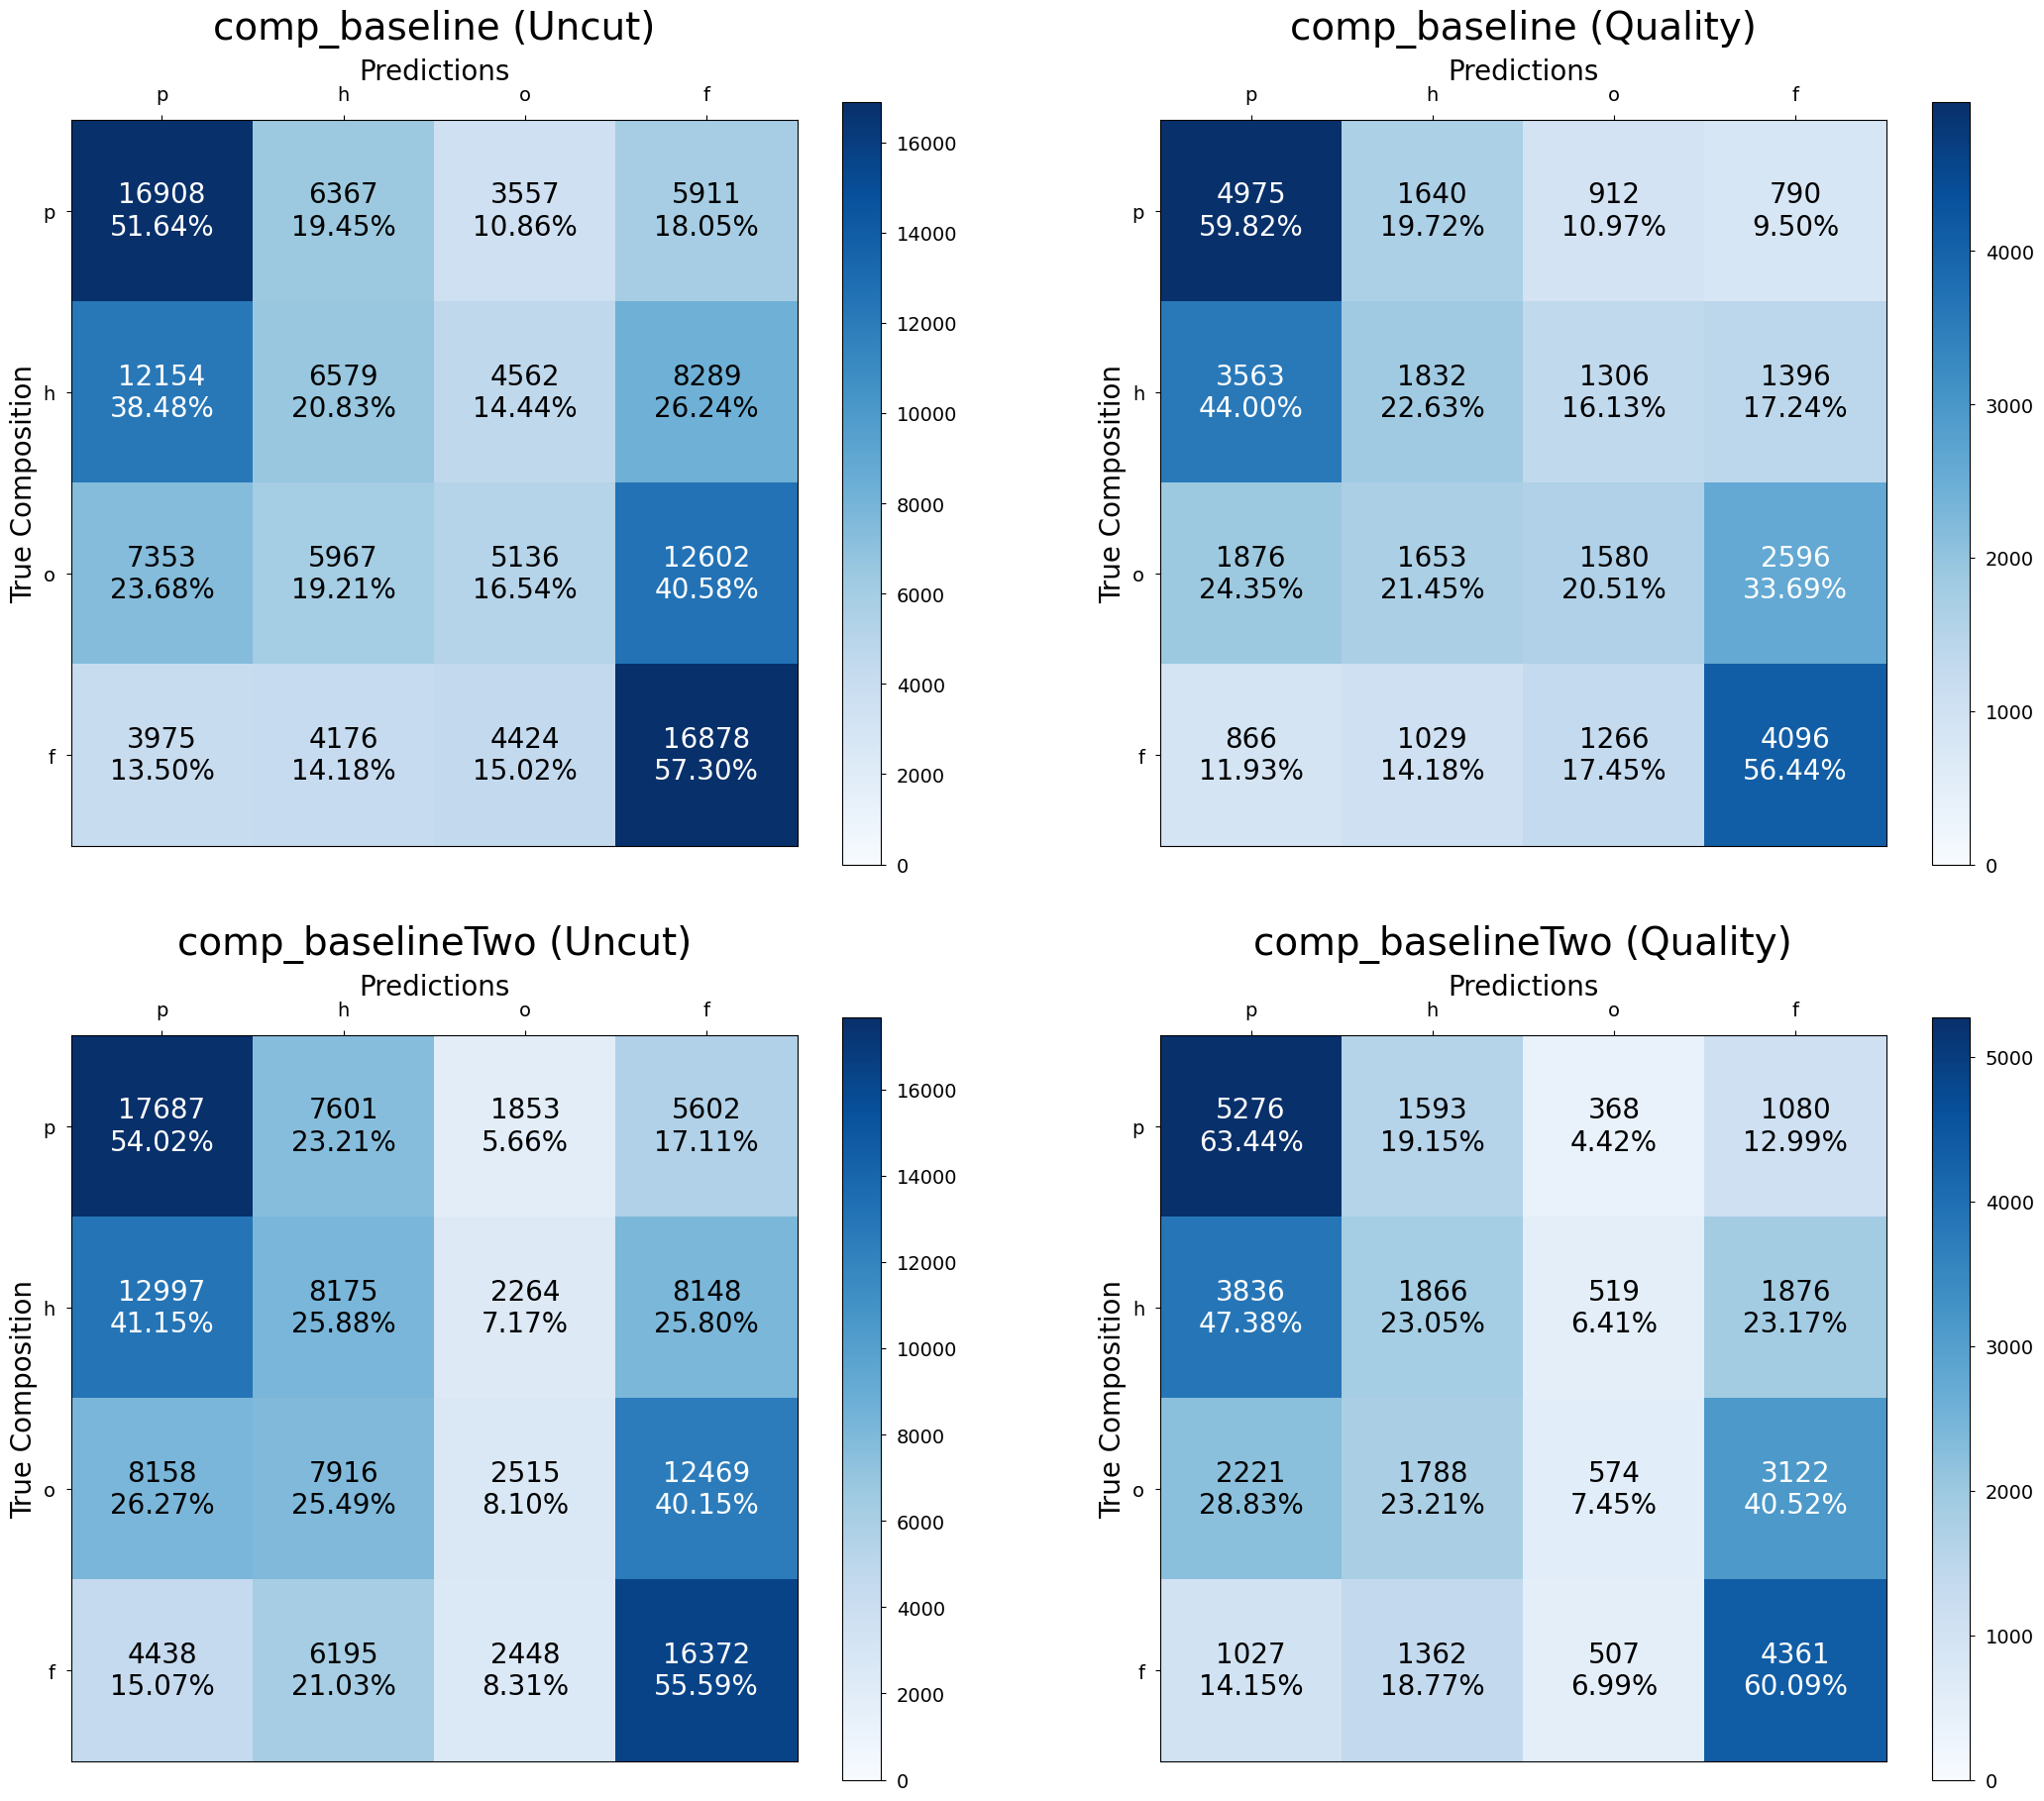

In [8]:
# CONFIG FOR PLOT
cut_names = ['Uncut', 'Quality']

# CONFIG FOR TEXT
text_params = {'fontsize':20}
title_params = {'fontsize':28, 'pad':14}
label_params = {'fontsize':20}
tick_params = {'labelsize':14, 'pad':8, 'top':True, 'labeltop':True, 'bottom':False, 'labelbottom':False}

# VARIABLES FOR PLOT
ncols, nrows = len(cut_names), len(model_parameters)
weights_to_categories = {1:0, 4:1, 16:2, 56:3}
categories_to_comp = {0:'p', 1:'h', 2:'o', 3:'f'}

# Create the plot/subplots.
fig, axs = plt.subplots(figsize=(13*ncols, 11*nrows), ncols=ncols, nrows=nrows)

# If we are assessing only one model, add an artificial dimension.
if nrows == 1: axs = np.array([axs])
# Loop over the models.
for model_ax, model_name in zip(axs, model_parameters):
    # Get the compositions that the model trained on.
    training_comp = model_parameters[model_name]['training_nuclei']
    # Get the compositions that the model will be assessing.
    assessment_comp = model_parameters[model_name]['assessment_nuclei']
    # If we are assessing only one cut, add an artificial dimension.
    if ncols == 1: model_ax = np.array([model_ax])
    # Loop over the cuts.
    for ax, cut_name in zip(model_ax, cut_names):

        # Get cuts for the model reconstructions and event parameters.
        reconstructions_cut, events_cut = get_cuts(cuts[model_name], event_parameters, cut_name)

        # Convert the composition array from storing atomic weights to storing the appropriate output category
        categorized_comp = np.vectorize(lambda x: weights_to_categories.get(x))(event_parameters['comp'][events_cut])
        
        # Create an empty confusion matrix.
        confusion_matrix = np.zeros((len(assessment_comp), len(training_comp)), dtype=int)
        # Loop over each (true value, prediction) pair.
        for true_category, predicted_category in zip(categorized_comp, reconstructions[model_name][reconstructions_cut]):
            # Due to the one-hot encoding scheme, there are occasions where an event will be categorized outside of the prediction sphere
            # TODO: Expand this into proper error handling
            if categories_to_comp.get(predicted_category) not in training_comp:
                continue
            # Populate the confusion matrix.
            confusion_matrix[assessment_comp.index(categories_to_comp.get(true_category)), 
                                training_comp.index(categories_to_comp.get(predicted_category))] += 1

        # Plot the confusion matrix.
        im = ax.imshow(confusion_matrix, interpolation='nearest', vmin=0, cmap=plt.cm.Blues)

        # Create a colorbar.
        cbar = fig.colorbar(im, ax=ax)
        cbar.ax.tick_params(**tick_params)
        
        # Normalize the confusion matrix to get percentages.
        normalized_confusion_matrix = confusion_matrix / np.clip(confusion_matrix.sum(axis=1), 1, None)[:, np.newaxis]

        # Create a color threshold to switch from light/dark text.
        color_threshold = confusion_matrix.max() / 2
        # Loop over each square in the confusion matrix.
        for row, col in np.ndindex(confusion_matrix.shape):
            # Write the text in each box of the confusion matrix.
            ax.text(col, row, f'{confusion_matrix[row, col]}\n{100*normalized_confusion_matrix[row, col]:.2f}%',
                    horizontalalignment='center', verticalalignment='center',
                    color='white' if confusion_matrix[row, col] > color_threshold else "black",
                    **text_params)

        # Move the true composition label to the top of the plot along with the tick markers
        ax.xaxis.set_label_position('top')

        # Set the axis tick labels to the string representation of each nuclei
        ax.set_xticks(np.arange(len(training_comp)), list(training_comp))
        ax.set_yticks(np.arange(len(assessment_comp)), list(assessment_comp))

        # Decorate the plot.
        ax.set_title(f'{model_name} ({cut_name})', **title_params)
        ax.set_xlabel('Predictions', **label_params)
        ax.set_ylabel('True Composition', **label_params)
        ax.tick_params(**tick_params)

### Accuracy as a Function of Energy

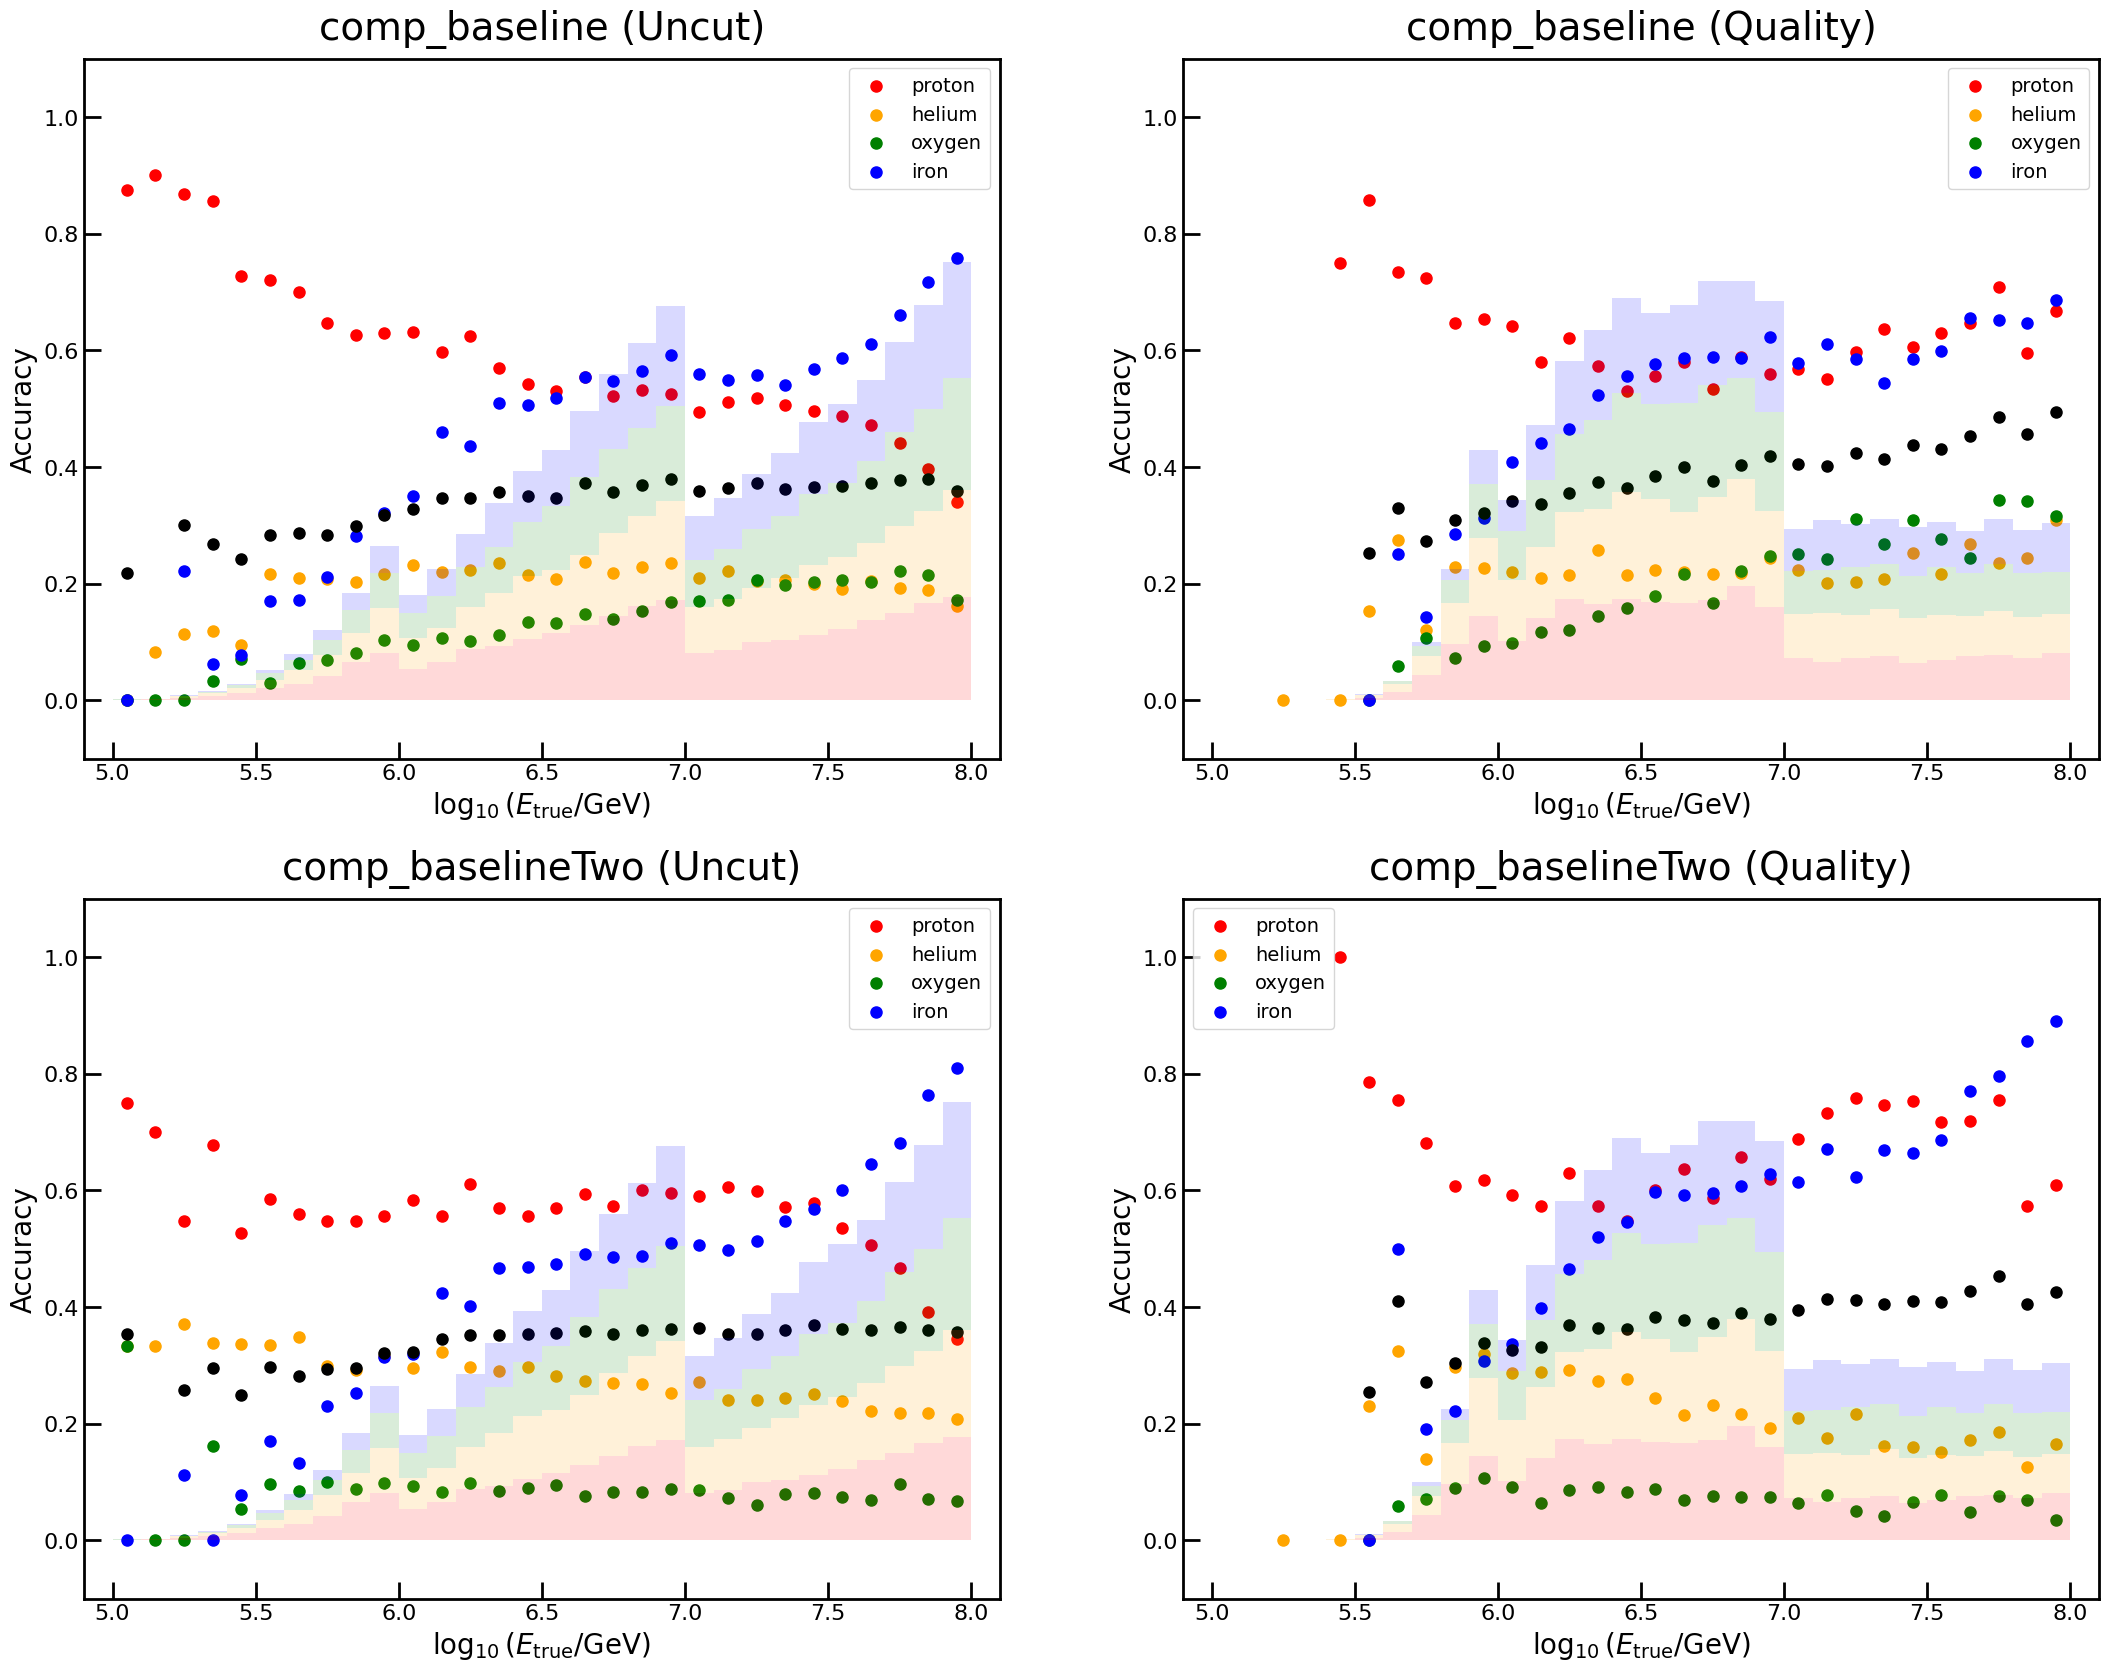

In [9]:
# CONFIG FOR PLOT
cut_names = ['Uncut', 'Quality']
energy_range = (5, 8)
bin_inc = 0.1
marker_size = 640*bin_inc

# CONFIG FOR TEXT
title_params = {'fontsize':28, 'pad':14}
label_params = {'fontsize':20}
tick_params = {'axis':'both', 'direction':'in', 'length':12, 'width':2, 'labelsize':16}
legend_params = {'fontsize':14}

# VARIABLES FOR PLOT
ncols, nrows = len(cut_names), len(model_parameters)
energy_min, energy_max = energy_range
nbins = int((1/bin_inc)*(energy_max-energy_min))
bin_edges = np.linspace(energy_min, energy_max, nbins+1)
bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2
accuracy_min, accuracy_max = 0, 1
comp_table = {
    'p': {'weight': 1,  'alias': 0, 'name': 'proton', 'color': 'red'},
    'h': {'weight': 4,  'alias': 1, 'name': 'helium', 'color': 'orange'},
    'o': {'weight': 16, 'alias': 2, 'name': 'oxygen', 'color': 'green'},
    'f': {'weight': 56, 'alias': 3, 'name': 'iron',   'color': 'blue'},
}

# Create the plot/subplots.
fig, axs = plt.subplots(figsize=(13*ncols, 10*nrows), ncols=ncols, nrows=nrows)

# If we are assessing only one model, add an artificial dimension.
if nrows == 1: axs = np.array([axs])
# Loop over the models.
for model_ax, model_name in zip(axs, model_parameters):
    # Save the number of compositions that the model will be assessing.
    num_categories = len(model_parameters[model_name]['assessment_nuclei'])
    # If we are assessing only one cut, add an artificial dimension.
    if ncols == 1: model_ax = np.array([model_ax])
    # Loop over the cuts.
    for ax, cut_name in zip(model_ax, cut_names):

        # Get cuts for the model reconstructions and event parameters.
        reconstructions_cut, events_cut = get_cuts(cuts[model_name], event_parameters, cut_name)

        # Create lists to store the counts and accuracies for each bin
        binned_accuracies, binned_comps = [], []
        # Loop over the model-specific assessment composition.
        for comp in model_parameters[model_name]['assessment_nuclei']:

            # Generate a mask for each nuclei represented as an integer array.
            nuclei_mask = (event_parameters['comp'][events_cut] == comp_table[comp]['weight']).astype(int)

            # Get all of the nuclei-specific correct predictions.
            correct_guesses = (reconstructions[model_name][reconstructions_cut] == comp_table[comp]['alias']) & nuclei_mask

            # Bin each nuclei-specific event that was correctly predicted by its energy.
            binned_correct_guesses, _ = np.histogram(event_parameters['energy'][events_cut],
                                                     bins=bin_edges, weights=correct_guesses)
            
            # Bin each nuclei-specific event by its energy.
            binned_comp, _ = np.histogram(event_parameters['energy'][events_cut],
                                          bins=bin_edges, weights=nuclei_mask)
            
            # Compute the nuclei-specific accuracies for each bin.
            # No values in a particular bin means doing a 0/0 division.
            with np.errstate(divide='ignore', invalid='ignore'):
                binned_accuracy = binned_correct_guesses / binned_comp

            # Save the nuclei-specific histogram.
            binned_comps.append(binned_comp)
            # Save the nuclei-specific accuracies.
            binned_accuracies.append(binned_accuracy)

            # Create scatter plot of the accuracy for each composition.
            ax.scatter(bin_centers, binned_accuracy, s=marker_size, label=comp_table[comp]['name'], color=comp_table[comp]['color'])
        
        # Create scatter plot of the average accuracies.
        ax.scatter(bin_centers, np.mean(binned_accuracies, axis=0), s=marker_size, color='black')

        # Create a stacked histogram representing the total number of counts for each bin.
        ax.hist(np.repeat(bin_edges[:-1], num_categories).reshape(-1, num_categories),
                bins=bin_edges, density=True, weights=np.asarray(binned_comps).transpose(), histtype='barstacked',
                color=[comp_table[c]['color'] for c in model_parameters[model_name]['assessment_nuclei']], alpha=0.15)
        
        # Set the axes limits to be within reasonable ranges.
        ax.set_xlim(energy_min-bin_inc, energy_max+bin_inc)
        ax.set_ylim(accuracy_min-bin_inc, accuracy_max+bin_inc)
        
        # Decorate the plot.
        ax.set_title(f'{model_name} ({cut_name})', **title_params)
        ax.set_xlabel(r'$\log_{10}(E_{\mathrm{true}}/\mathrm{GeV})$', **label_params)
        ax.set_ylabel('Accuracy', **label_params)
        ax.tick_params(**tick_params)
        for axis in ['top','bottom','left','right']:
            ax.spines[axis].set_linewidth(2)
        ax.legend(**legend_params)
            

## Training Resource Consumption

### Access the Condor Logs

In [23]:
# Get the directory of where all the logs are located
LOG_DIR = os.path.join(os.getcwd(), 'condor', 'logs')

# Get every log file within the user's home directory with it's file path
ALL_LOGS = glob(os.path.join(LOG_DIR, '*.log'))

# Create a second list that only contains the name of the model pertaining to said log
LOG_NAMES = []
for log in ALL_LOGS:
    LOG_NAMES.append(log[log.rfind('/')+1:log.find('.log')])

# Create a third list that only contains the logs of the models that are being assessed 
MODEL_LOGS = sorted(set(LOG_NAMES).intersection(model_list))
print(MODEL_LOGS)

# Create the database file
DB_FILE = open(LOG_DIR +"/modelTimes.txt", "a")

# Create a list of file objects of each log
# Exists as a function so time and memory can be ran seperately while still properly closing files after opening
def get_log_files():
    LOG_FILES = []
    for log in MODEL_LOGS:
        LOG_FILES.append(
            open(LOG_DIR +'/'+log+'.log')
        )
    return LOG_FILES

['comp_js3']


### Assess Time Needed to Train

In [24]:
#Take in the file
#Take this time: 005 (238358931.000.000) 2025-09-11 21:57:58 Job terminated.
##Which is seen right above the run-time stats
#And subtract it from: 040 (238358931.000.000) 2025-09-11 19:19:24 Started transferring input files
##Which is when files start being transfered 

# Track what job is currently being worked on 
jobCount = 1
# Create list to store dicts of modelNameJobNum and CPU Time
JOB_INFO = []
# Go model by model 
for file in get_log_files():
    # On new file, reset variables to inital state
    jobCount = 1
    # Go line by line 
    for line in file.readlines():
        # Get the start time
        if line.find("Started transferring input files") != -1:  
            #Calculate year, month, day of the start
            year  = int(line[ line.find('-')-4 :  line.find('-')    ])
            month = int(line[ line.find('-')+1 : line.rfind('-')    ]) 
            day   = int(line[line.rfind('-')+1 : line.rfind('-') + 3])
            #Calculate hour, minute, second of the start
            hr    = int(line[ line.find(':')-2 :  line.find(':')    ])
            mn    = int(line[ line.find(':')+1 : line.rfind(':')    ])
            sc    = int(line[line.rfind(':')+1 : line.rfind(':') + 3])
            #Create the datetime object for the start
            startTime = dt(year, month, day, hr, mn, sc)        
        # Get the end time
        elif line.find("Job terminated") != -1 and line.find("of its own accord") == -1:
            #Calculate year, month, day of the end
            year  = int(line[ line.find('-')-4 :  line.find('-')    ])
            month = int(line[ line.find('-')+1 : line.rfind('-')    ]) 
            day   = int(line[line.rfind('-')+1 : line.rfind('-') + 3])
            #Calculate hour, minute, second of the end
            hr    = int(line[ line.find(':')-2 :  line.find(':')    ])
            mn    = int(line[ line.find(':')+1 : line.rfind(':')    ])
            sc    = int(line[line.rfind(':')+1 : line.rfind(':') + 3])
            #Create the datetime object for the end
            endTime = dt(year, month, day, hr, mn, sc-1)

            #Calculate the time difference between endTime and startTime
            CPUTime = endTime - startTime;
            #Get the name of the file
            fileName= file.name[file.name.rfind('/')+1:file.name.find('.log')]
            #Append a dictionary into JOB_INFO
            JOB_INFO.append({
                "modelAndJob" : fileName + ", Iteration "+str(jobCount),
                "CPUTimeSeconds" : CPUTime.total_seconds()
            })
            #Iterate jobCount
            jobCount+=1
        # If the line doesn't have data that we want
    # Close the file
    file.close()

for job in JOB_INFO:
    lineOne = job["modelAndJob"] 
    lineTwo = "\tCPU Runtime: " + str(td(seconds=job["CPUTimeSeconds"]))
    print("Time to train " + lineOne +":")
    print(lineTwo)
    print()
    DB_FILE.write(lineOne+"\n"+lineTwo+"\n----\n")

Time to train comp_js3, Iteration 1:
	CPU Runtime: 5:20:08



### Implementation:

### Current Problems: